In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,8551,-8010,541,153,289,1261,8108,10998,0,...,41861,3332,0,3999,8854,4413,18737,442,-867,273
1,2014-06-30,9438,-8607,831,296,1284,1523,7212,11406,0,...,42542,3421,0,4281,9377,4802,19669,1818,-904,273
2,2014-09-30,9287,-8179,1108,615,544,1380,7384,10646,0,...,41687,3424,0,3036,8122,4578,18233,1447,-719,273
3,2014-12-31,9615,-8109,1506,835,865,1344,7885,11570,0,...,43865,3764,0,2845,8823,4819,19898,2105,-1001,273
4,2015-03-31,10406,-8892,1514,895,683,1629,8952,12446,0,...,44488,3928,0,3151,9352,4217,19805,725,-705,273


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,3533,96376,10335,0,414,15832,10639,38065,7295,-3724
36,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
37,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
38,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
39,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
36,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
37,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
38,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
39,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
36,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
37,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
38,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
39,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,66.954483,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,0.5524,0.4476,27.124504,9.615846,118.352941,3.951653,0.063267,0.017893,0.01462,0.026466
1,2014-04-28,66.548088,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,0.5524,0.4476,27.124504,9.615846,118.352941,3.951653,0.063267,0.017893,0.01462,0.026466
2,2014-05-05,62.111534,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,0.5524,0.4476,27.124504,9.615846,118.352941,3.951653,0.063267,0.017893,0.01462,0.026466
3,2014-05-12,63.378326,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,0.5524,0.4476,27.124504,9.615846,118.352941,3.951653,0.063267,0.017893,0.01462,0.026466
4,2014-05-19,65.311424,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,0.5524,0.4476,27.124504,9.615846,118.352941,3.951653,0.063267,0.017893,0.01462,0.026466


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,66.954483,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,3.951653,0.063267,0.017893,0.01462,0.026466,29.866951,0.790459,0.534399,1.073751,3.490942
1,2014-04-28,66.548088,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,3.951653,0.063267,0.017893,0.01462,0.026466,29.685667,0.785661,0.531155,1.070507,3.469753
2,2014-05-05,62.111534,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,3.951653,0.063267,0.017893,0.01462,0.026466,27.706616,0.733284,0.495745,1.035097,3.238436
3,2014-05-12,63.378326,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,3.951653,0.063267,0.017893,0.01462,0.026466,28.271704,0.748239,0.505856,1.045208,3.304485
4,2014-05-19,65.311424,2014-03-31,8551.0,2.241758,84.703297,273.0,5236.0,19.179487,289.0,...,3.951653,0.063267,0.017893,0.01462,0.026466,29.134018,0.771061,0.521285,1.060637,3.405275


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

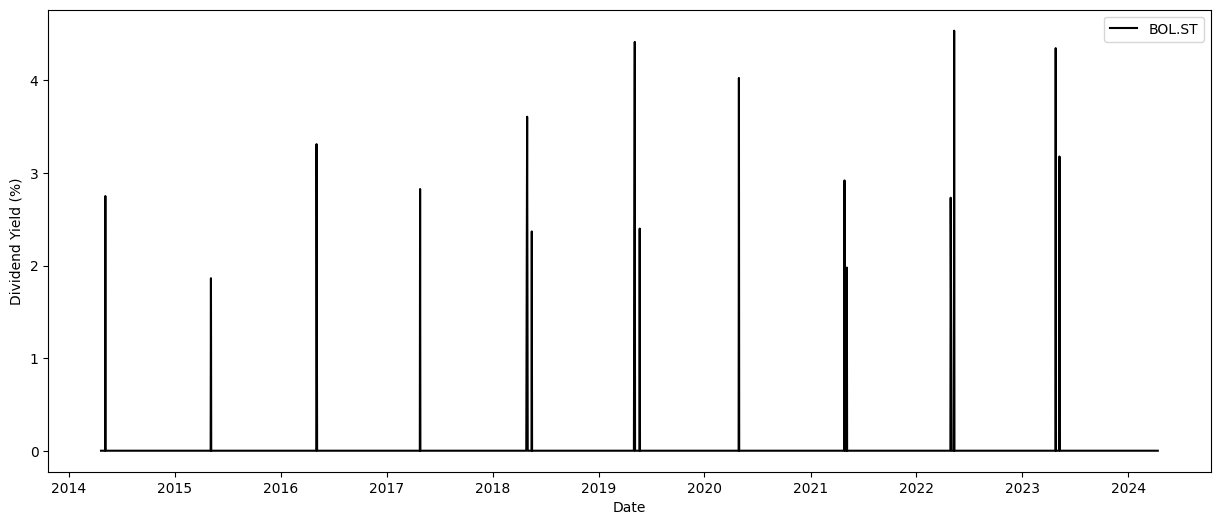

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.696018
share_price      1.000000
Name: share_price, dtype: float64


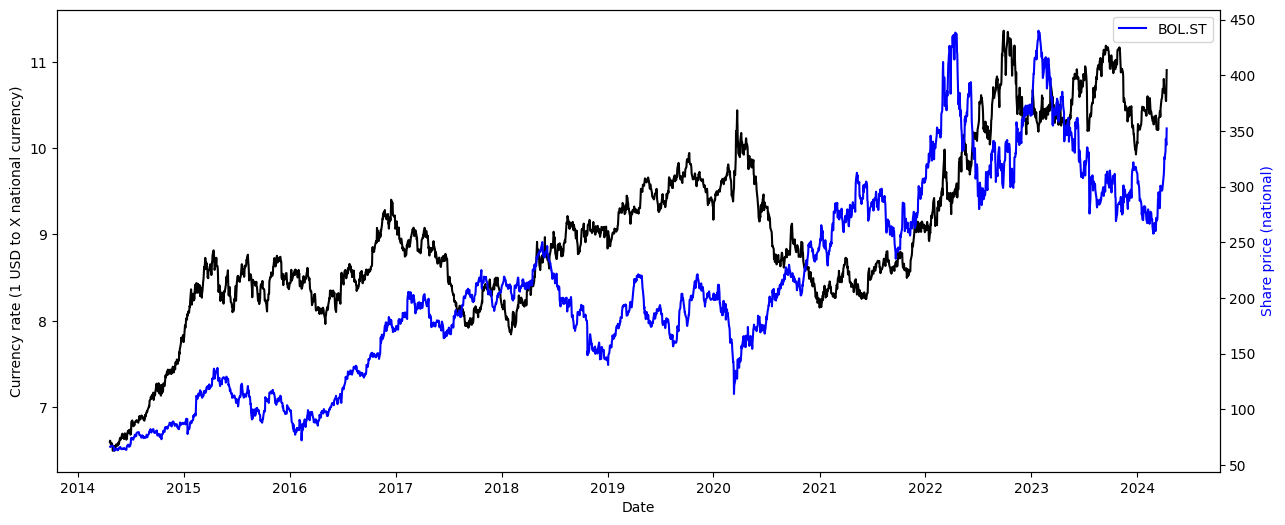

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

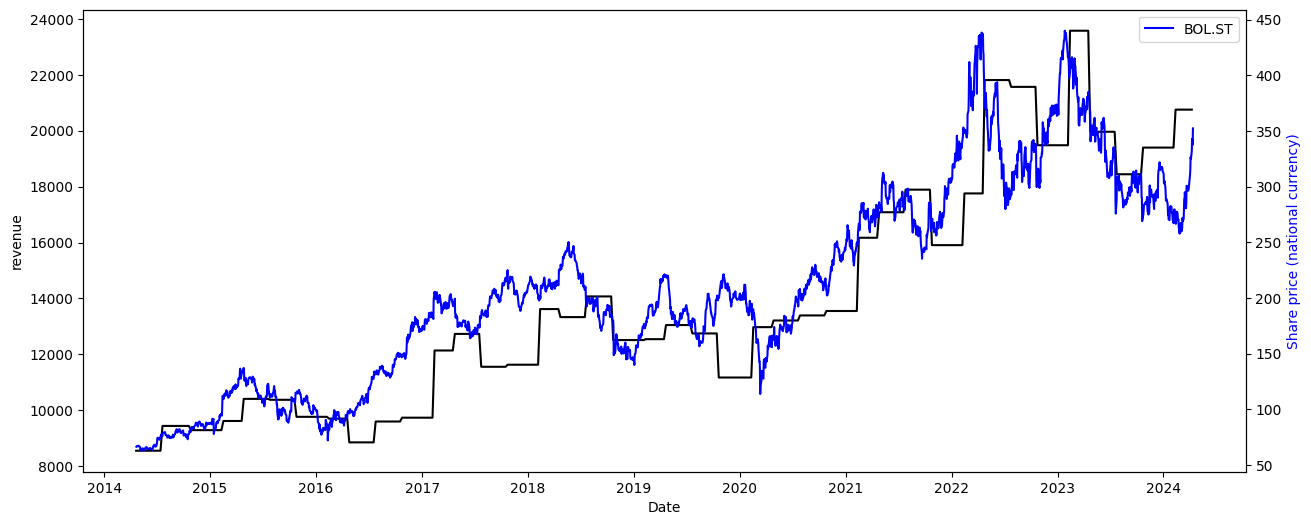

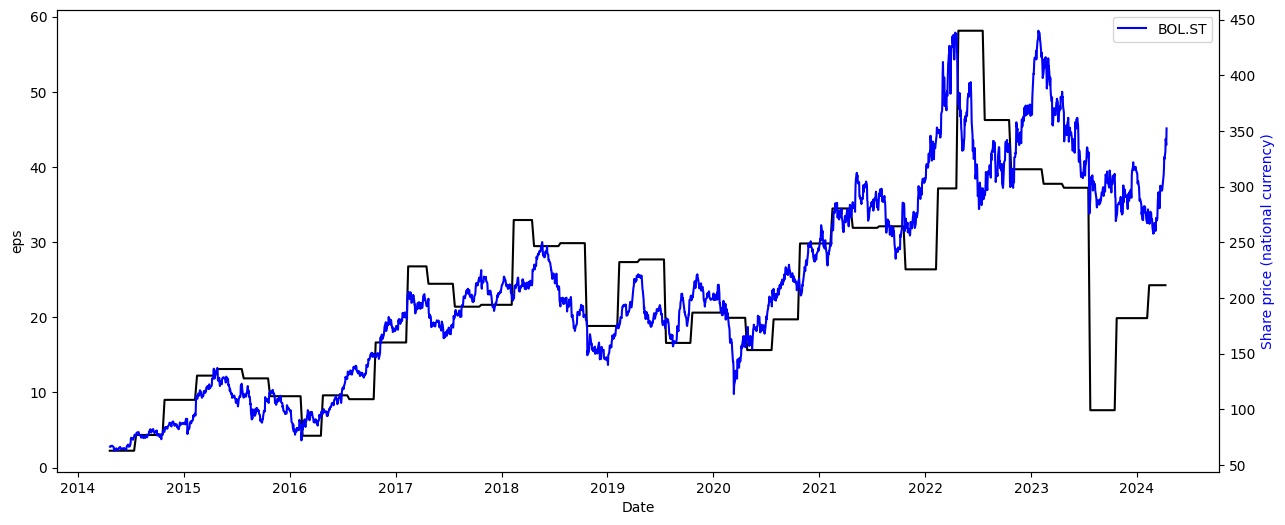

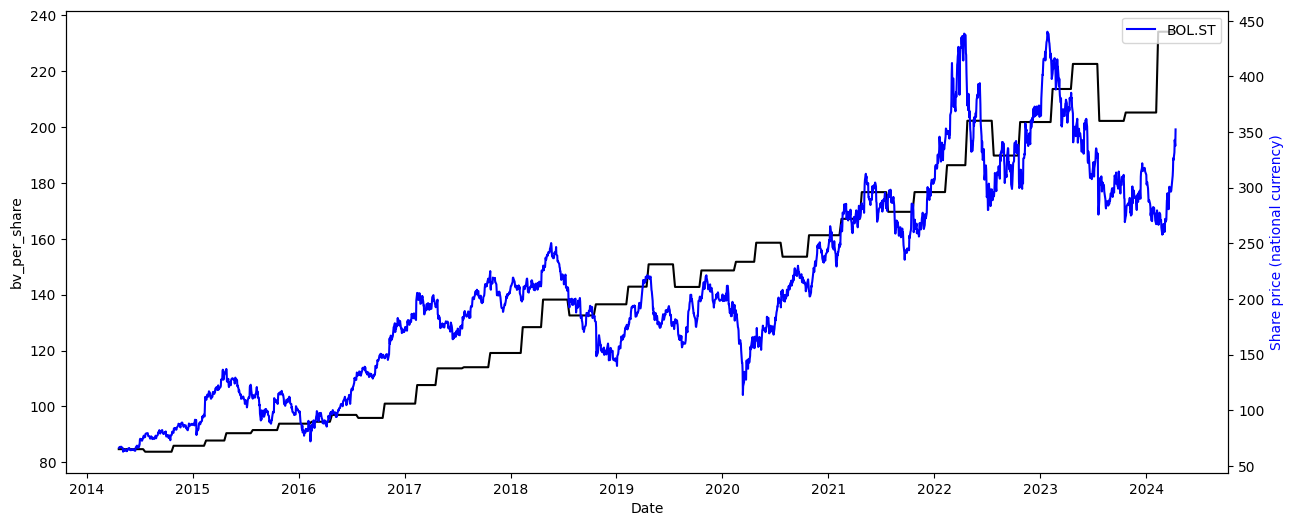

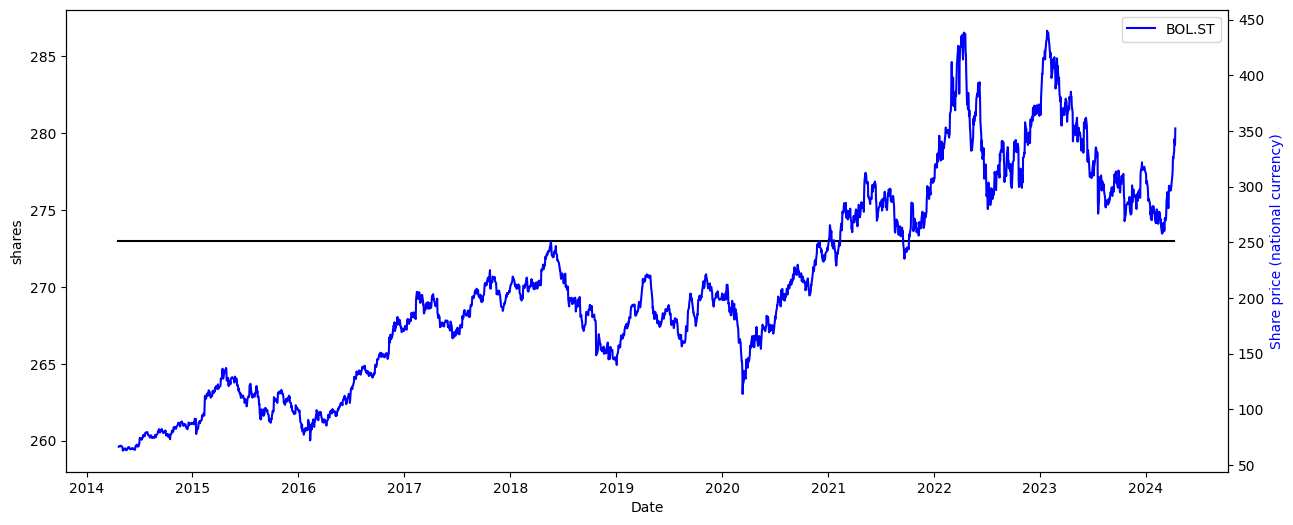

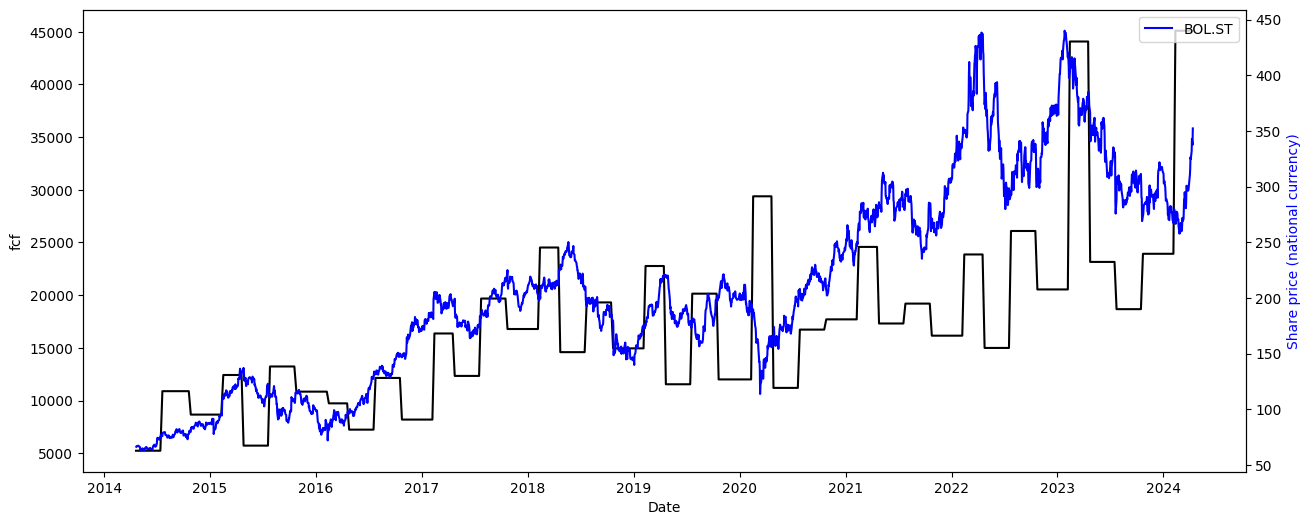

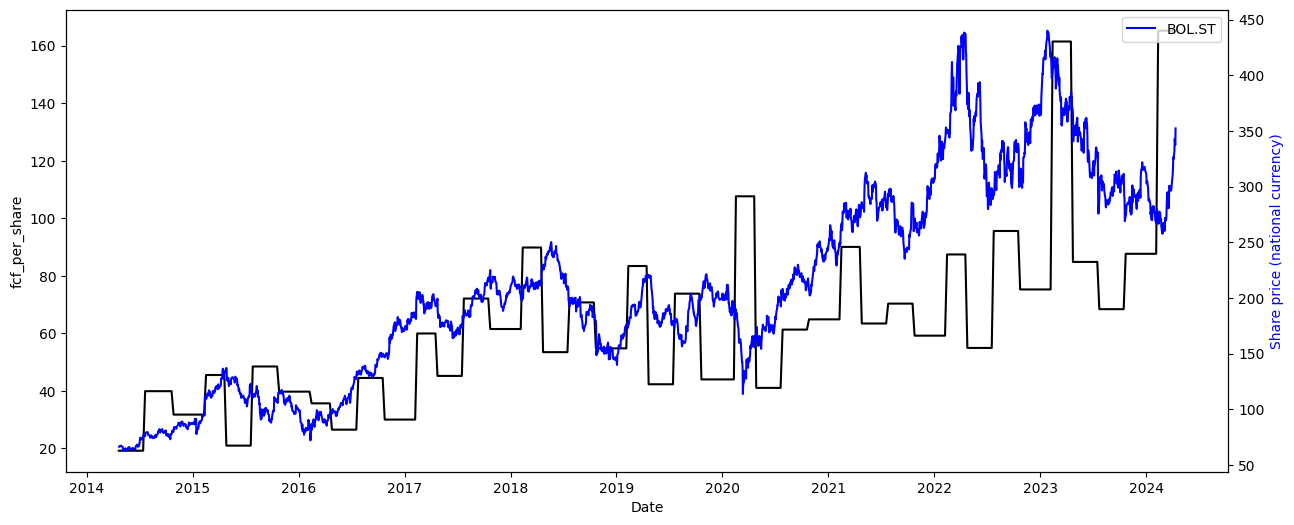

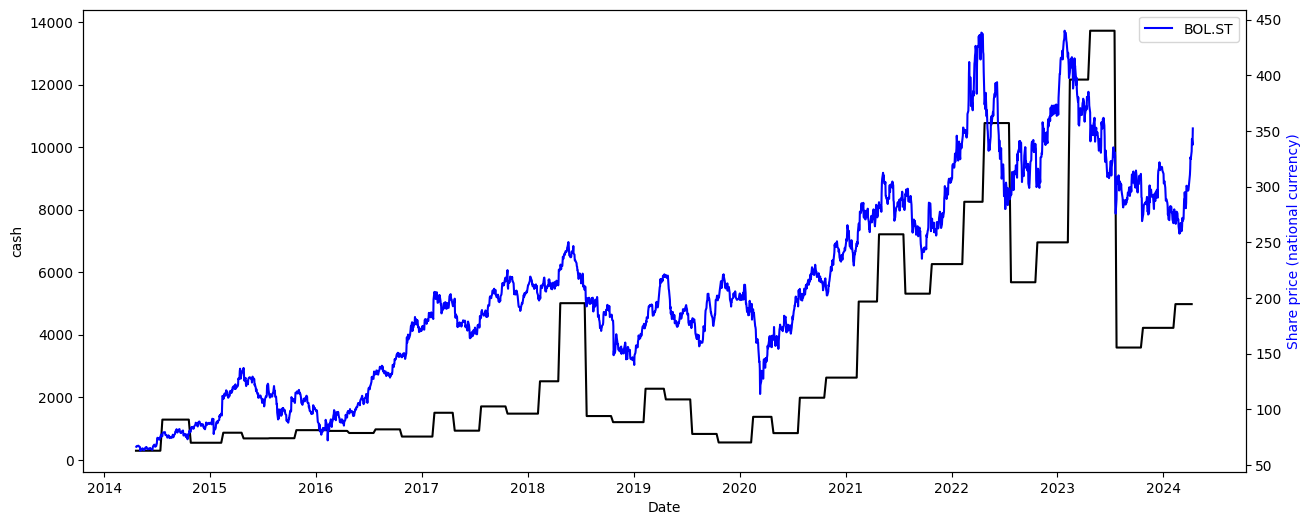

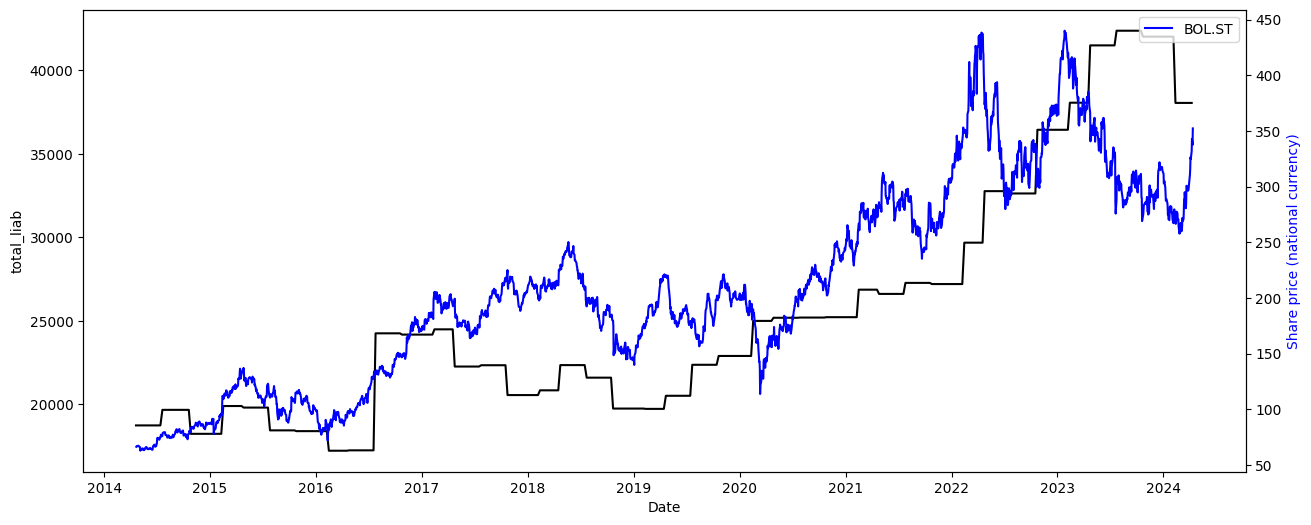

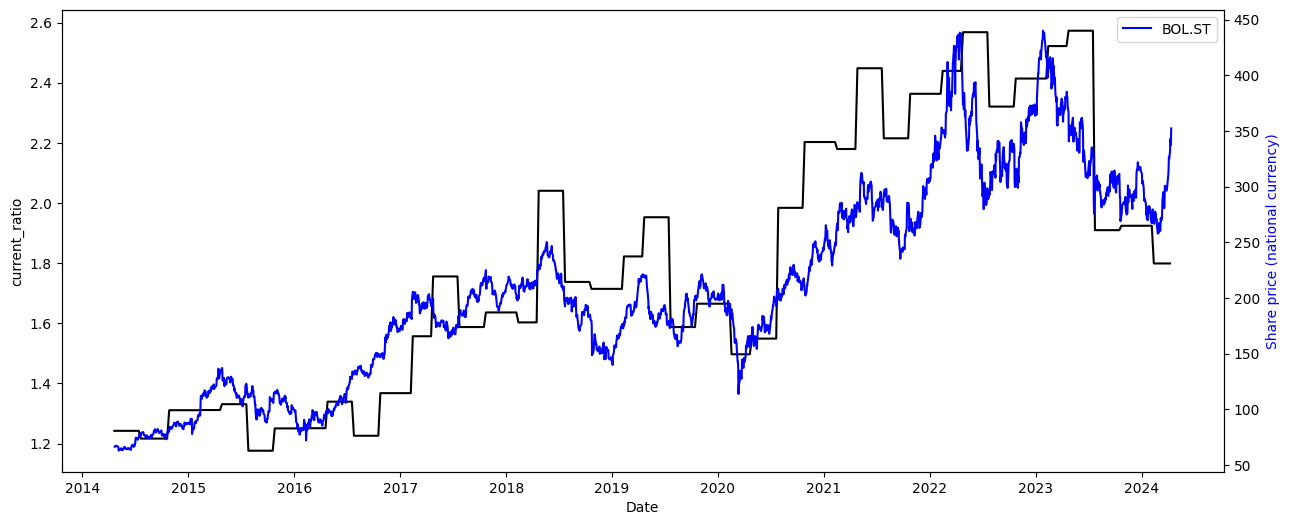

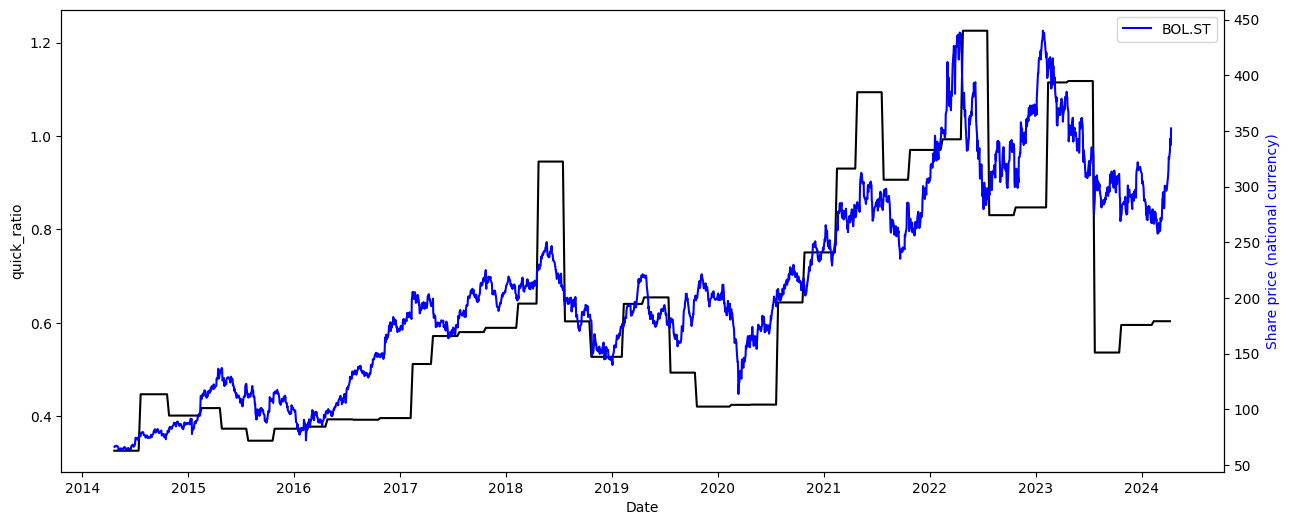

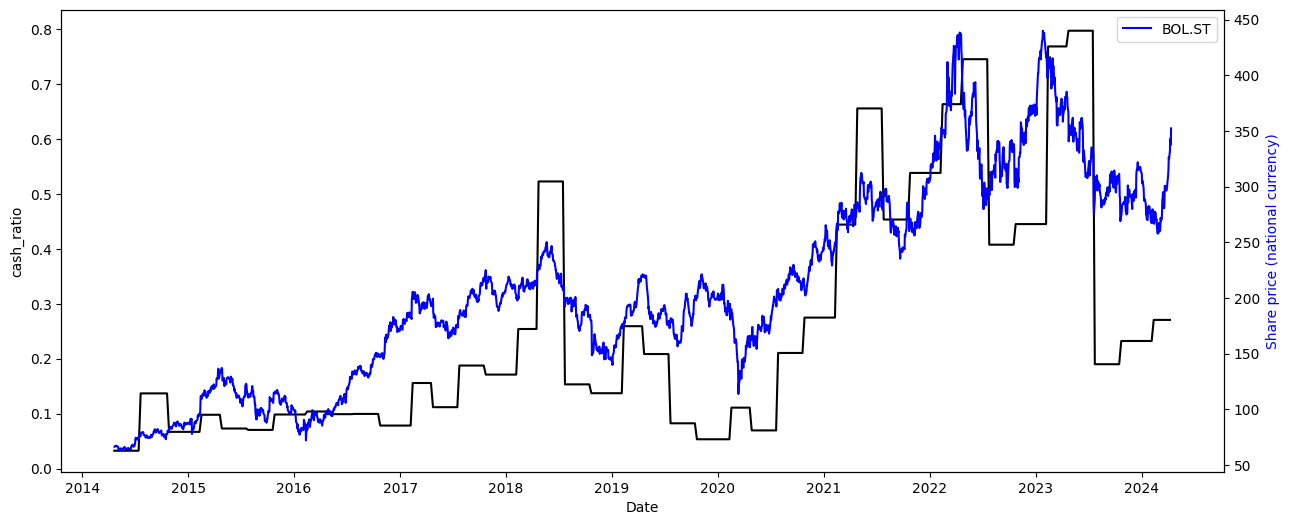

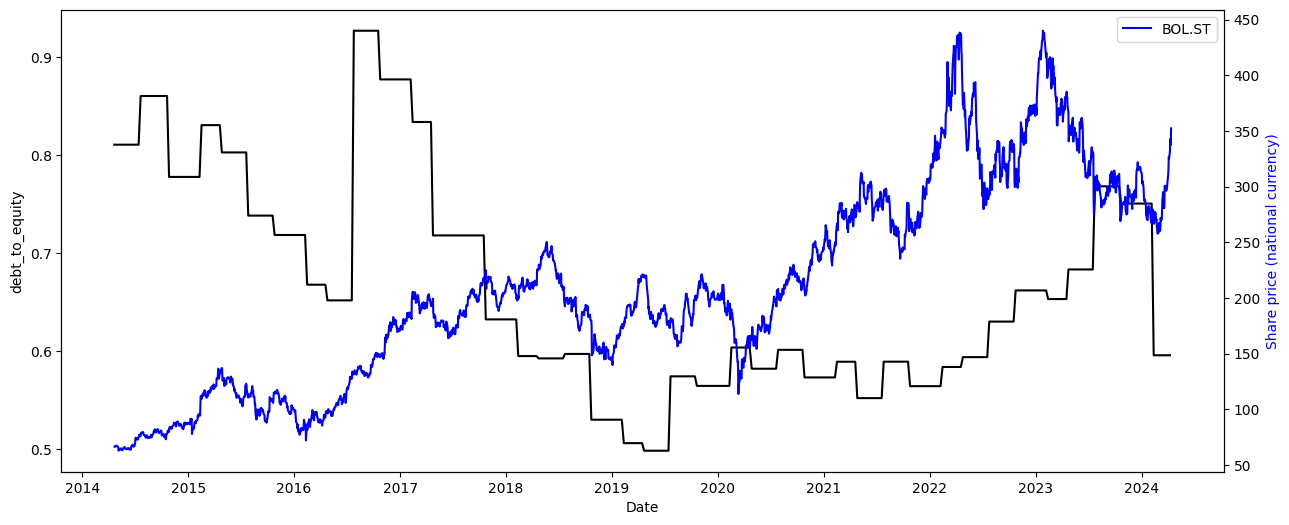

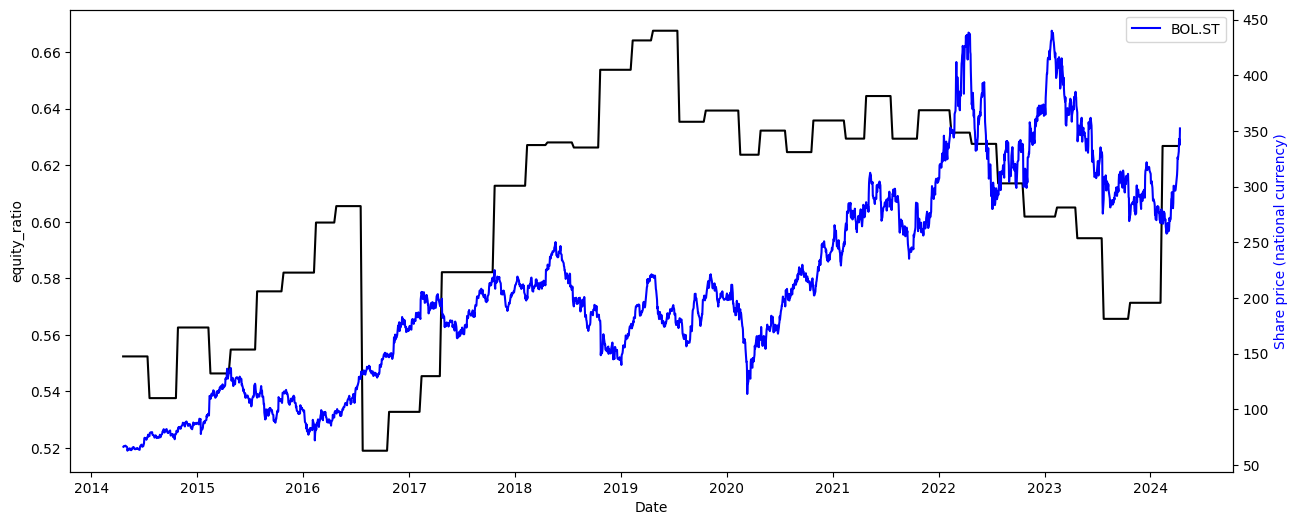

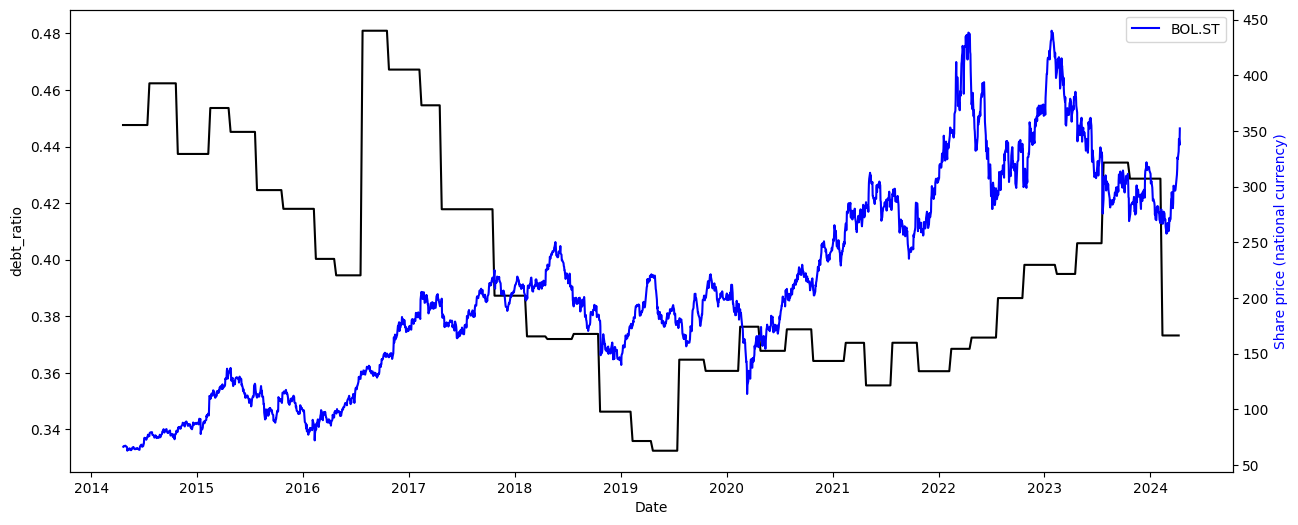

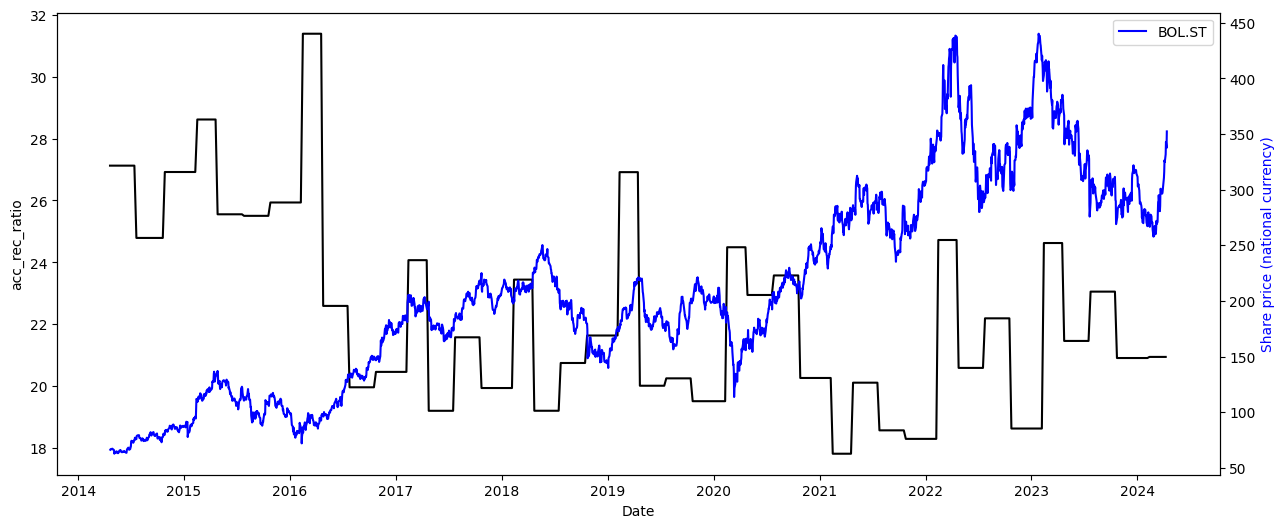

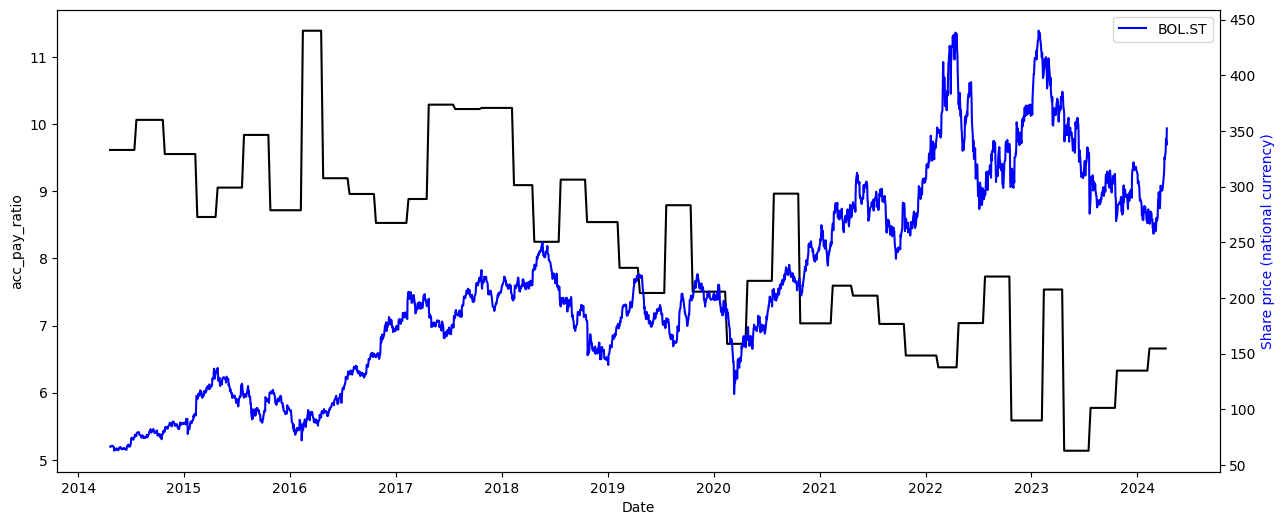

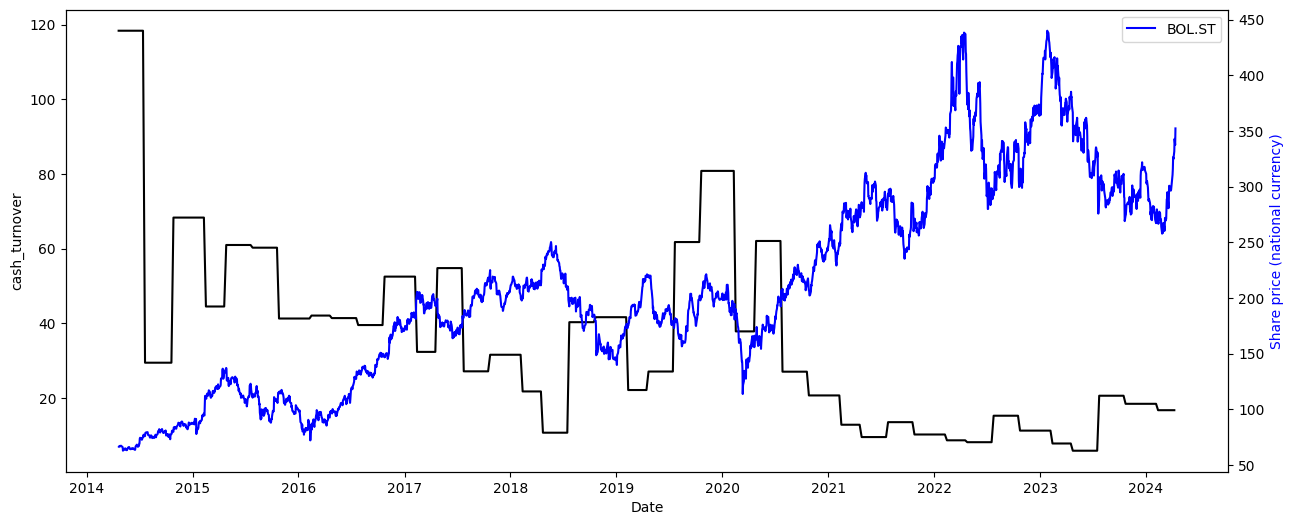

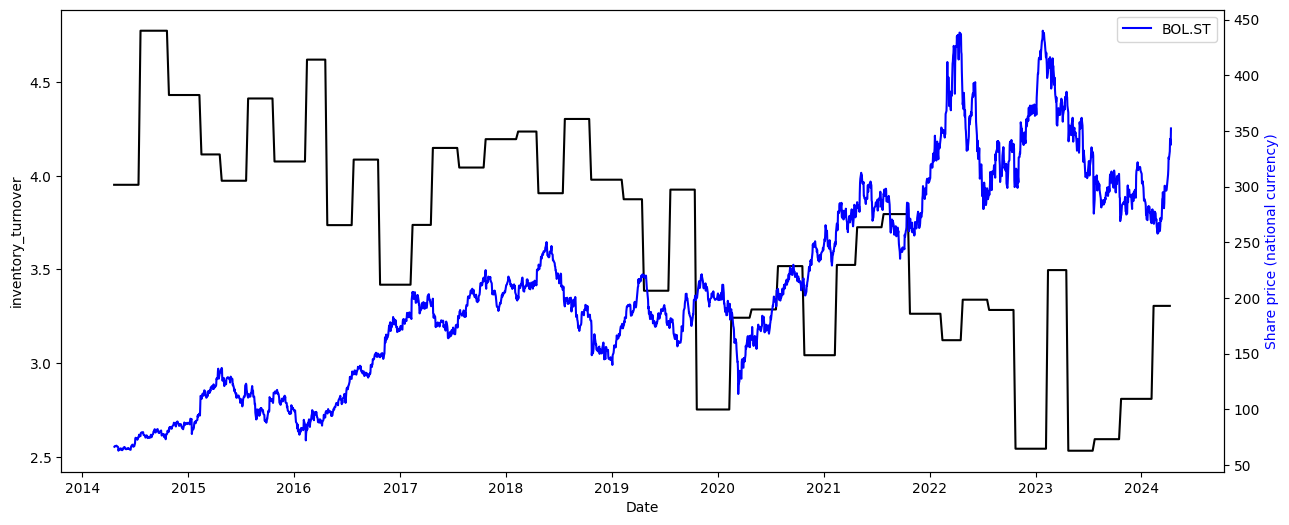

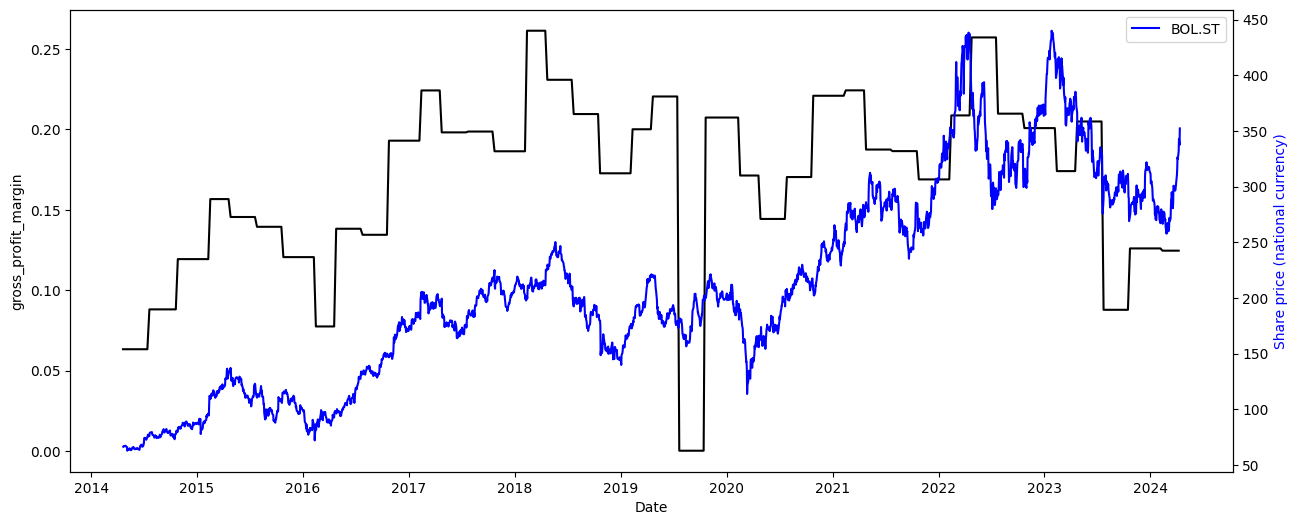

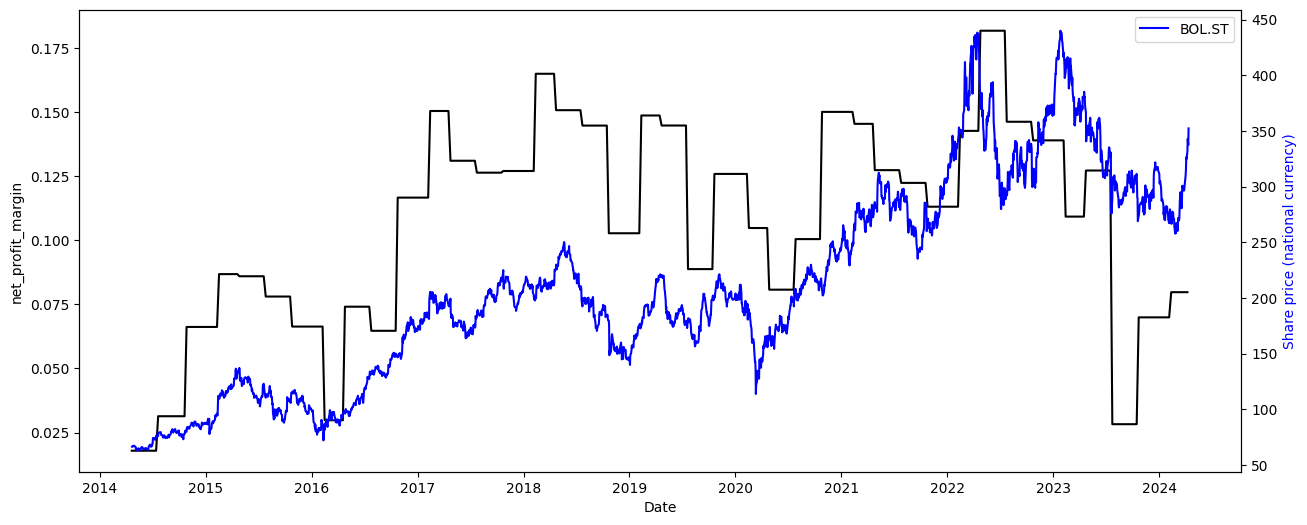

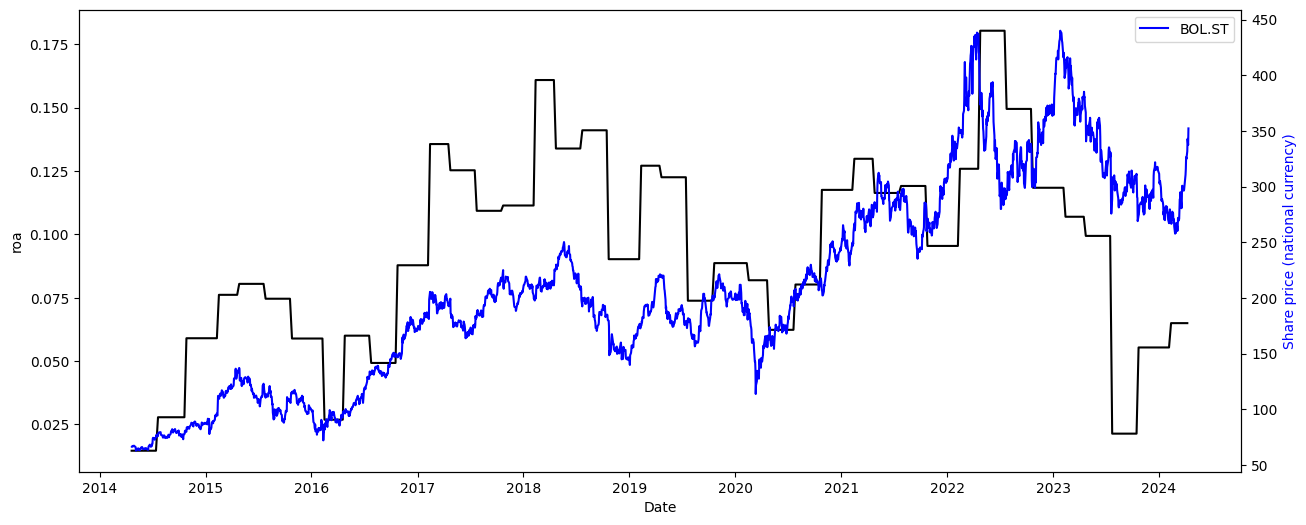

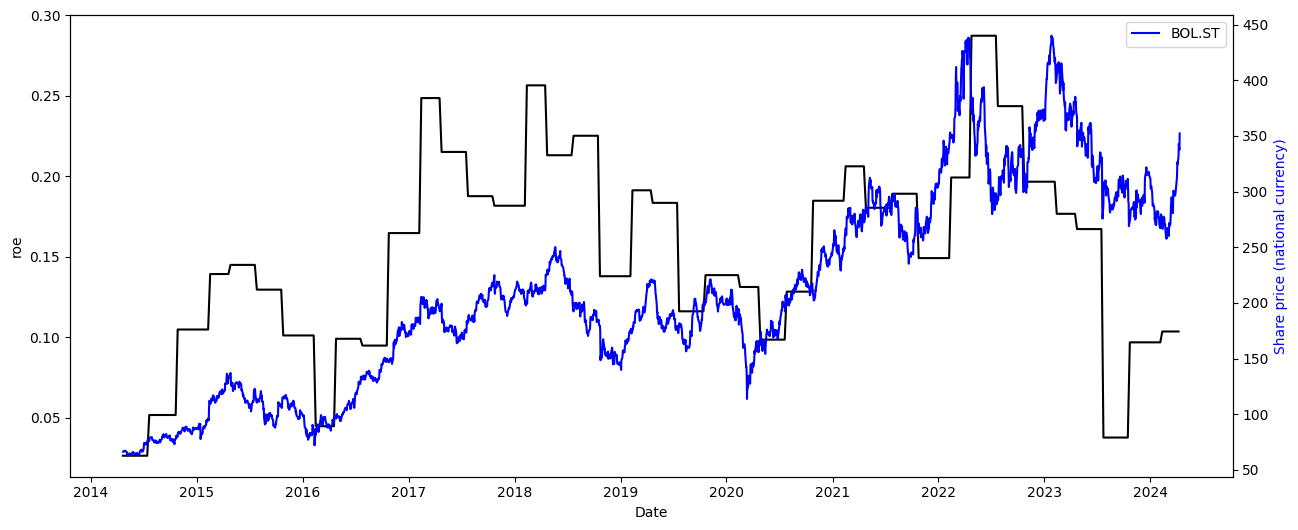

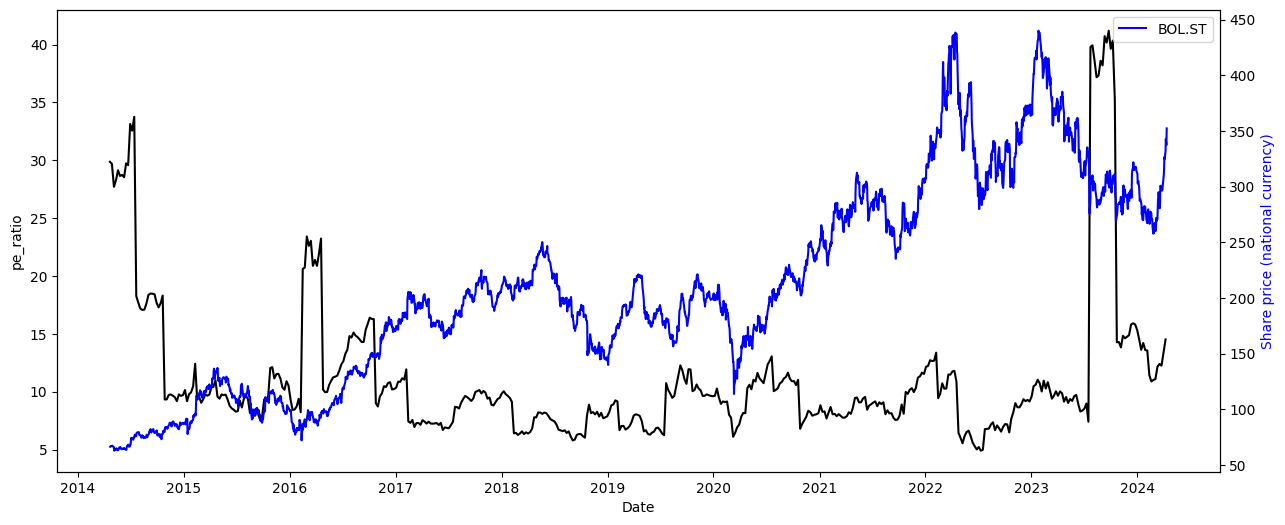

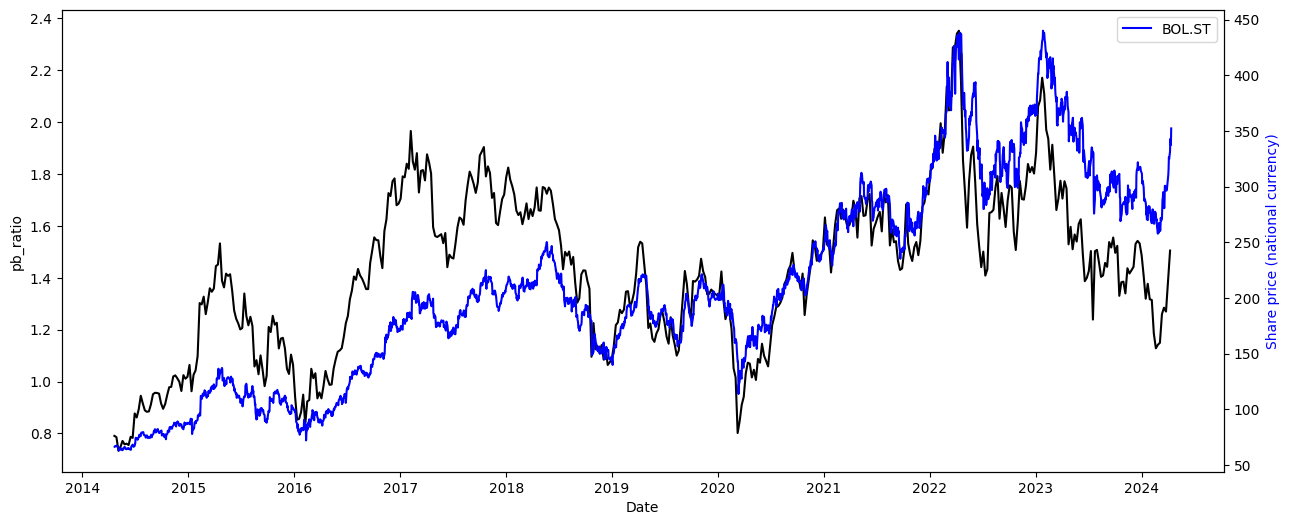

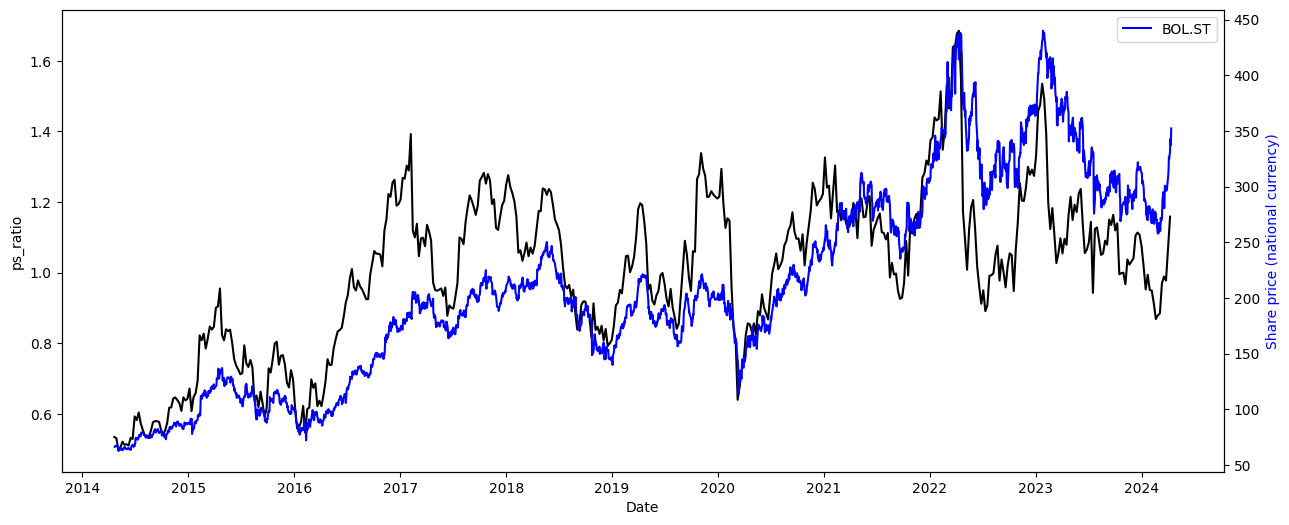

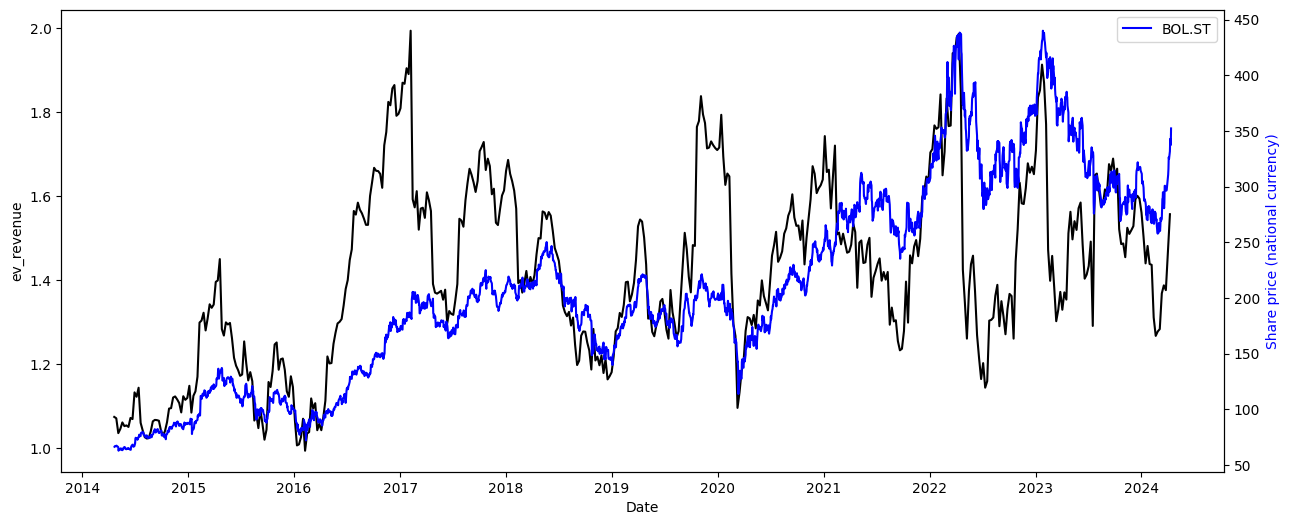

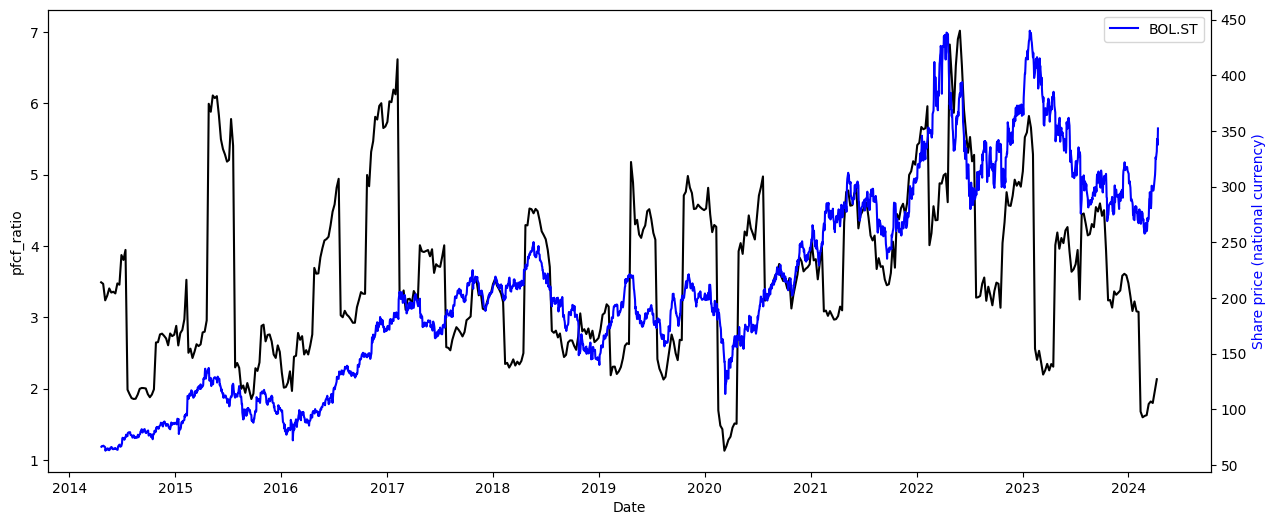

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

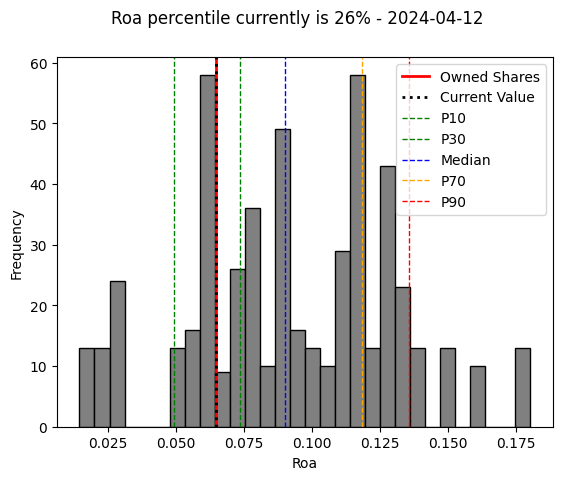

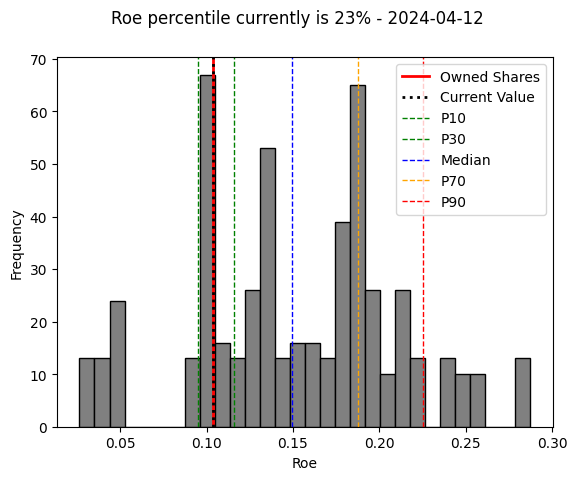

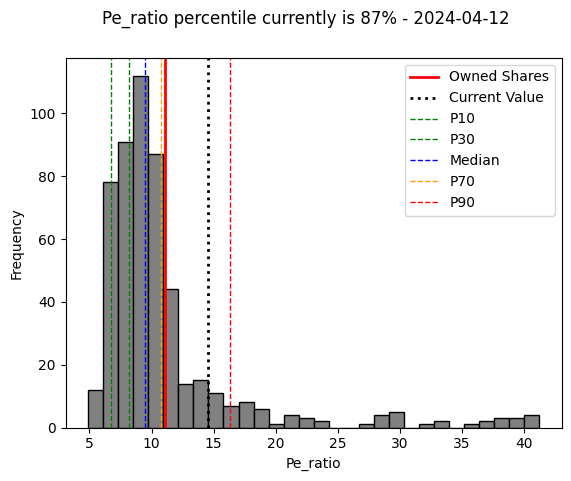

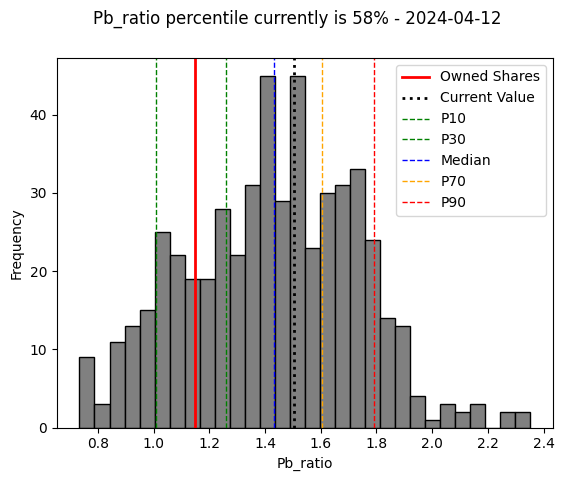

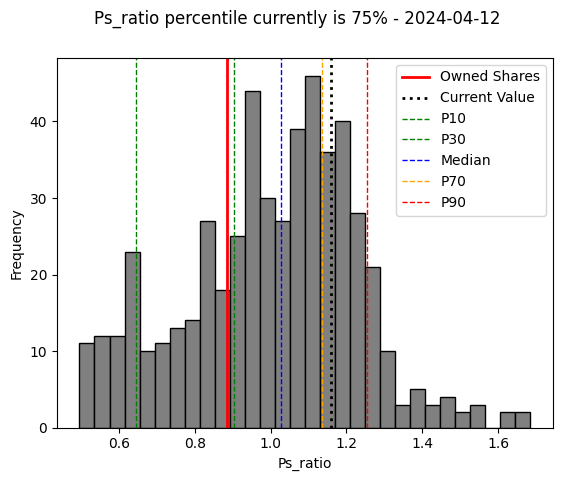

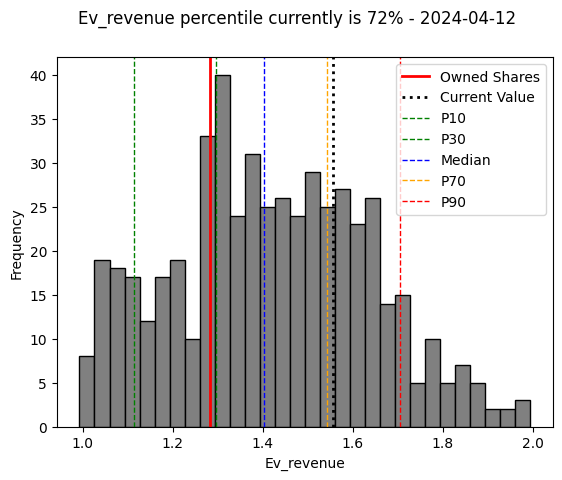

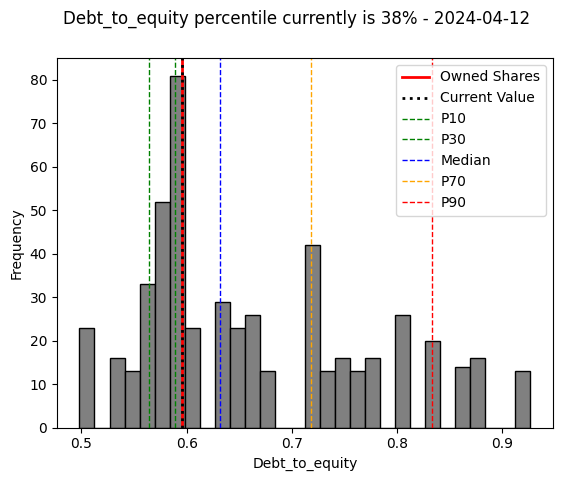

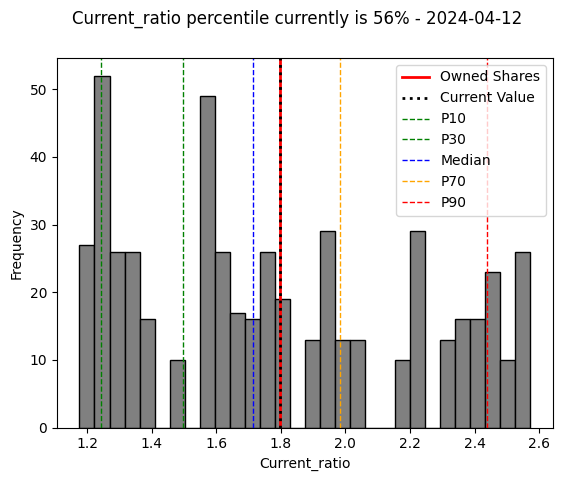

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989611,-0.724660,0.650114,0.531532,0.282415,-0.510679,0.608180
roe,0.989611,1.000000,-0.728389,0.678923,0.521816,0.299620,-0.392538,0.559227
pe_ratio,-0.724660,-0.728389,1.000000,-0.262268,-0.203042,-0.030357,0.401202,-0.238353
pb_ratio,0.650114,0.678923,-0.262268,1.000000,0.893982,0.786097,-0.149298,0.621450
ps_ratio,0.531532,0.521816,-0.203042,0.893982,1.000000,0.929086,-0.354424,0.653500
ev_revenue,0.282415,0.299620,-0.030357,0.786097,0.929086,1.000000,-0.088308,0.393596
debt_to_equity,-0.510679,-0.392538,0.401202,-0.149298,-0.354424,-0.088308,1.000000,-0.555242
current_ratio,0.608180,0.559227,-0.238353,0.621450,0.653500,0.393596,-0.555242,1.000000


35 timestemos have been found!


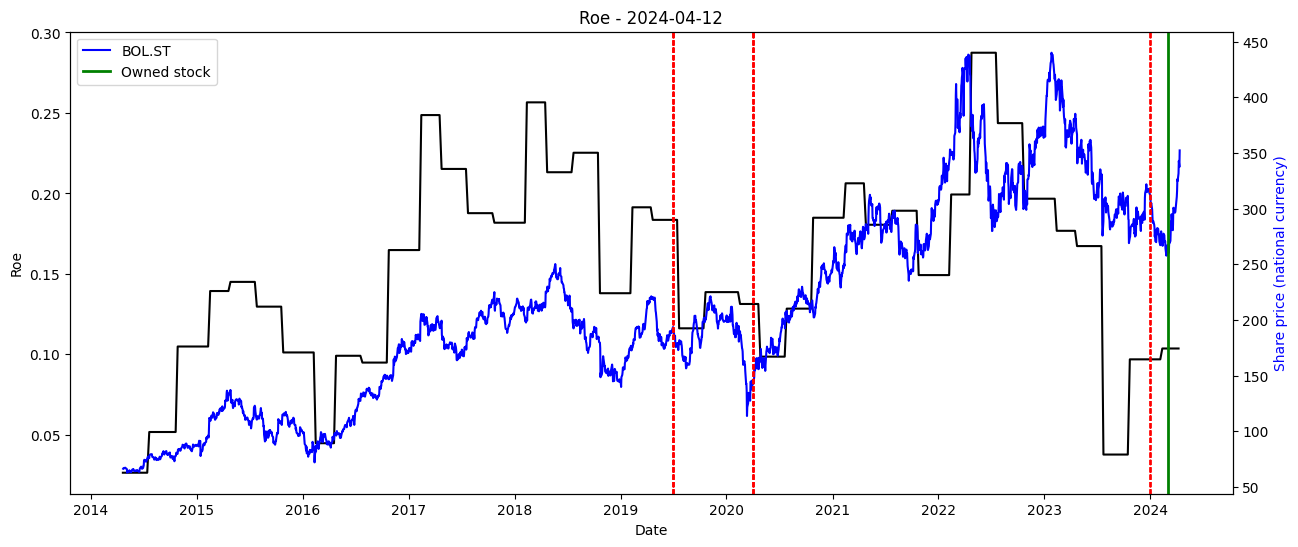

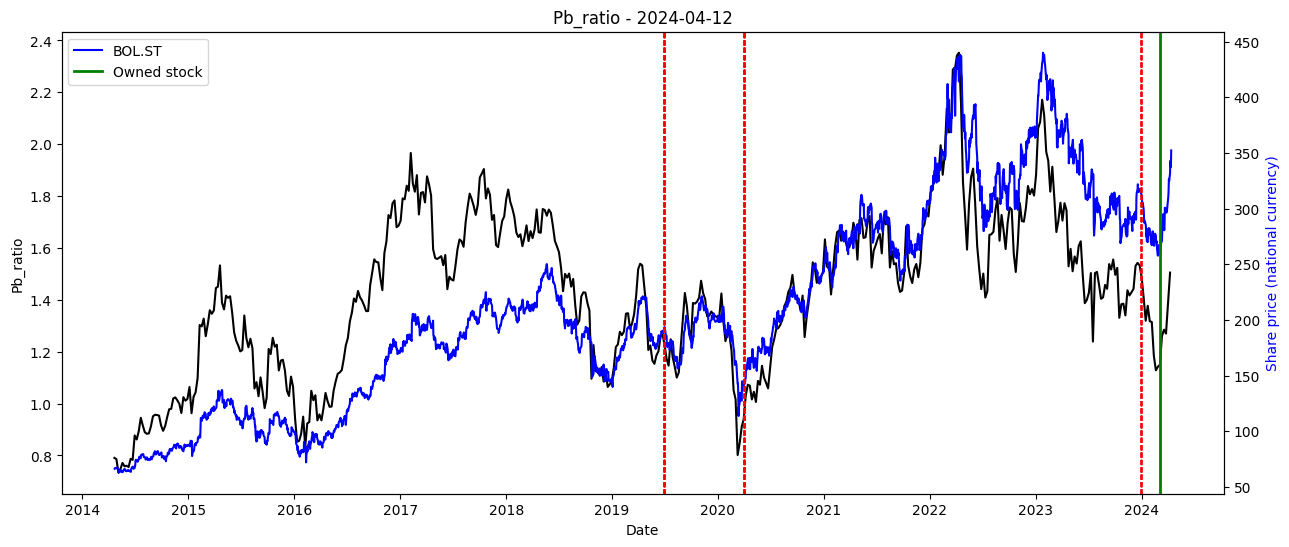

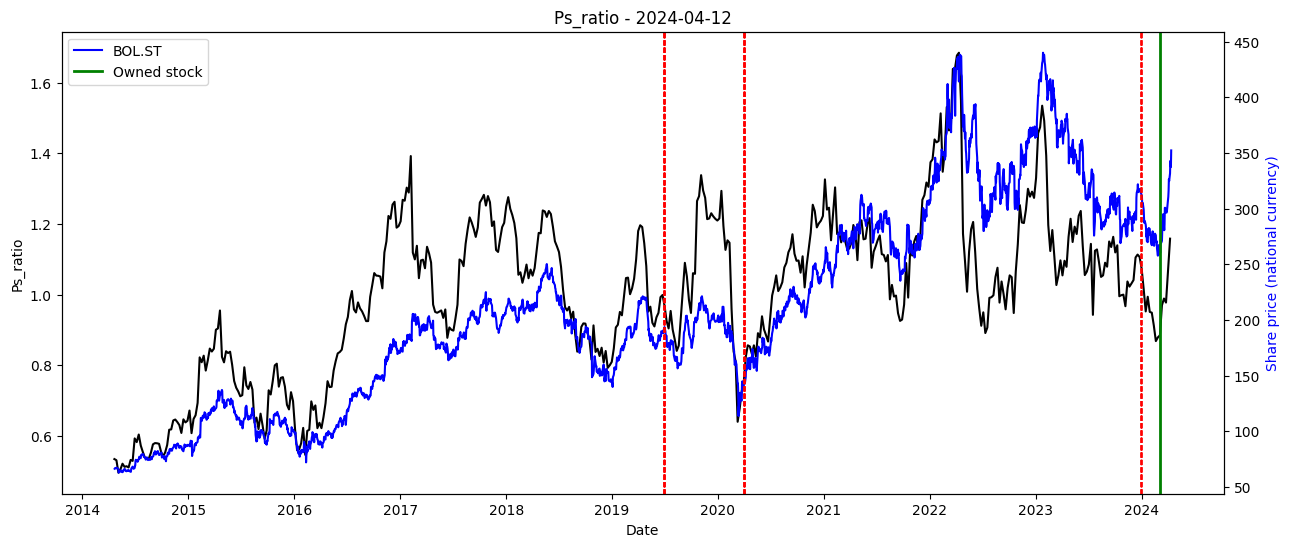

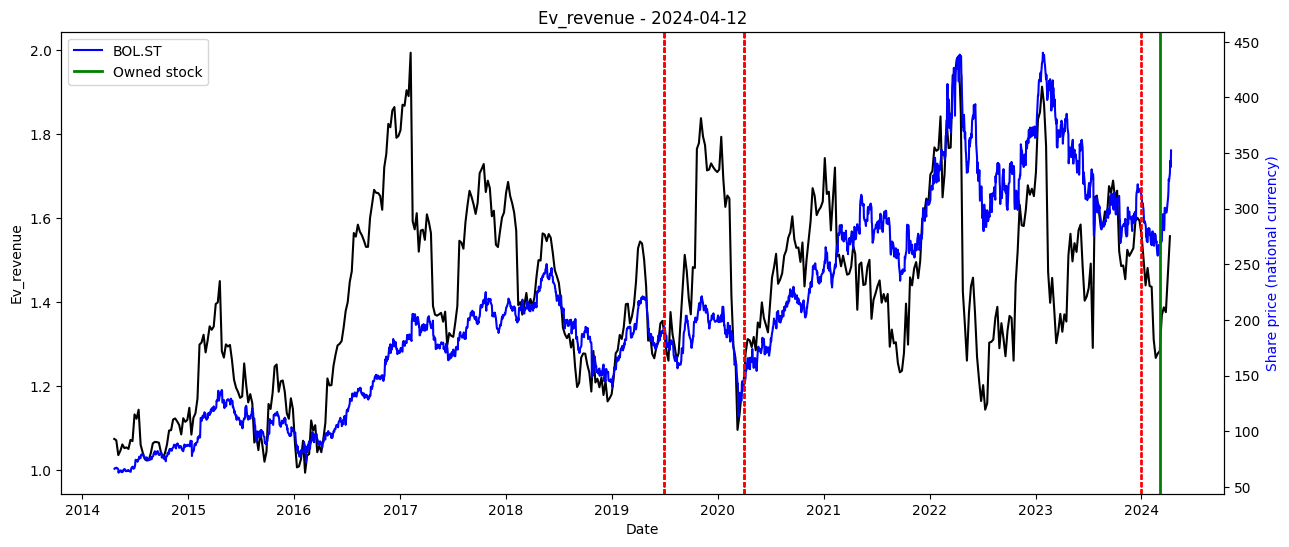

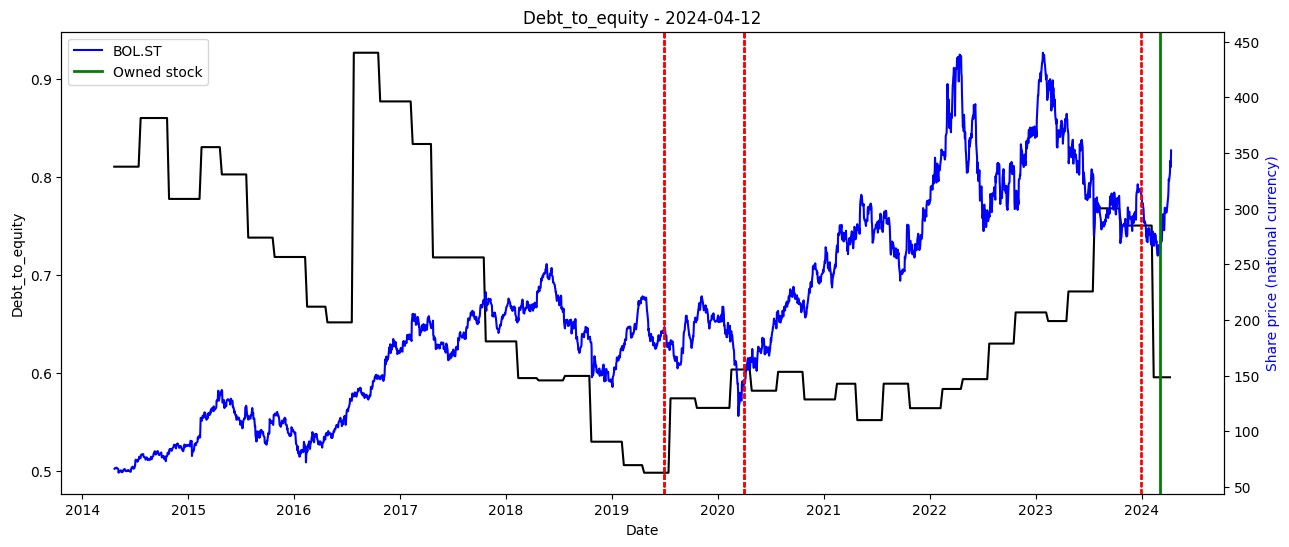

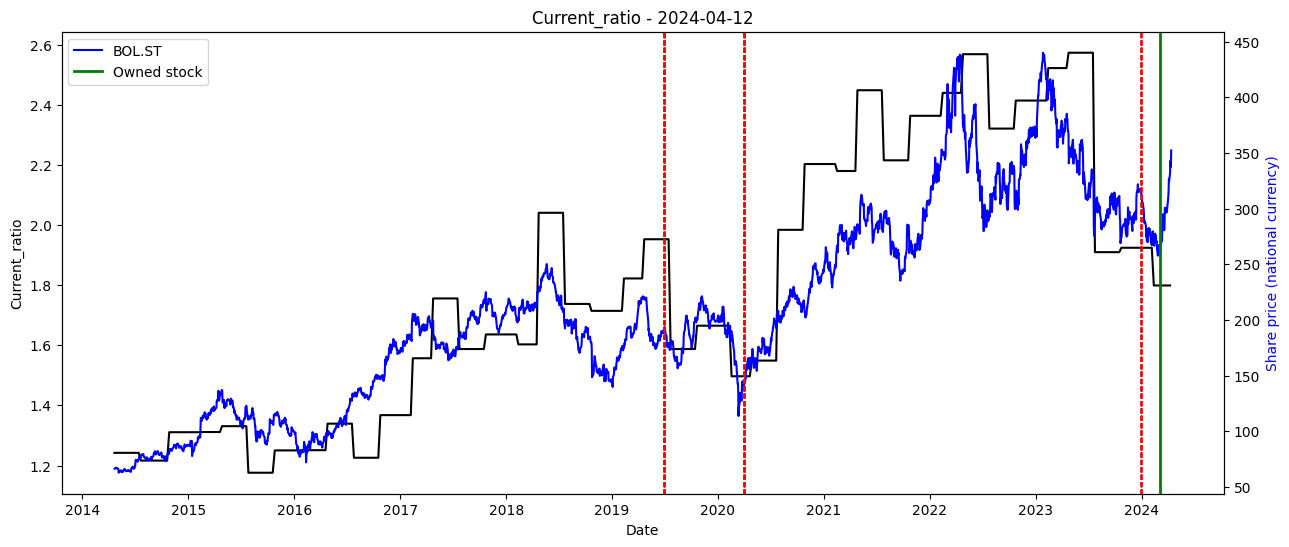

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )